In [105]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
# import interpretability_module as interp
# from utils import *
import pandas as pd
import sys
import time

from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix, f1_score, average_precision_score


In [106]:
telecom_data = pd.read_csv('../../../data/churn_examples/telecom_customer_churn.csv')

In [107]:
telecom_data.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

In [108]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

In [109]:
telecom_data['Customer Status'].value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64

In [110]:
telecom_data['Gender'].replace(['Female', 'Male'],[0, 1], inplace=True)
telecom_data['Married'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Online Security'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Online Backup'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Internet Service'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Phone Service'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Multiple Lines'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Device Protection Plan'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Premium Tech Support'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Offer'].replace(['None', '0','1','2','3','4'],[-1,0, 1,2,3,4], inplace=True)
telecom_data['Payment Method'].replace(['Bank Withdrawal', 'Credit Card','Mailed Check'],[0, 1,2], inplace=True)

telecom_data['Streaming TV'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Streaming Movies'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Streaming Music'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Paperless Billing'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['Unlimited Data'].replace(['No', 'Yes'],[0, 1], inplace=True)

telecom_data['Contract'].replace(['Month-to-Month', 'Two Year','One Year'],[1, 2,3], inplace=True)

telecom_data['Offer'].replace(['Offer A', 'Offer B','Offer C','Offer D','Offer E'],[0, 1,2,3,4], inplace=True)
telecom_data['Internet Type'].replace(['Fiber Optic','DSL','Cable'],[1,2,3], inplace=True)
telecom_data['Customer Status'].replace(['Stayed','Joined','Churned'],[1,1,0], inplace=True)


In [122]:
import numpy as np
import pandas as pd
# Follows algo from https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf

def c(size):
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1
    return 0


class LeafNode:
    def __init__(self, size, data):
        self.size = size
        self.data = data


class DecisionNode:
    def __init__(self, left, right, splitAtt, splitVal):
        self.left = left
        self.right = right
        self.splitAtt = splitAtt
        self.splitVal = splitVal


class IsolationTree:
    def __init__(self, height, height_limit):
        self.height = height
        self.height_limit = height_limit

    def fit(self, X: np.ndarray, improved=False):
        """
        Given a 2D matrix of observations, create an isolation tree. Set field
        self.root to the root of that tree and return it.

        If you are looking for an improved algorithm, check parameter "improved"
        and switch to your new functionality else fall back on your original code.
        """
        if improved:
            self.improved_fit(X)
        else:
            if self.height >= self.height_limit or X.shape[0] <= 2:
                self.root = LeafNode(X.shape[0], X)
                return self.root

            # Choose Random Split Attributes and Value
            num_features = X.shape[1]
            splitAtt = np.random.randint(0, num_features)
            splitVal = np.random.uniform(min(X[:, splitAtt]), max(X[:, splitAtt]))

            X_left = X[X[:, splitAtt] < splitVal]
            X_right = X[X[:, splitAtt] >= splitVal]

            left = IsolationTree(self.height + 1, self.height_limit)
            right = IsolationTree(self.height + 1, self.height_limit)
            left.fit(X_left)
            right.fit(X_right)
            self.root = DecisionNode(left.root, right.root, splitAtt, splitVal)
            self.n_nodes = self.count_nodes(self.root)
            return self.root

    def improved_fit(self, X: np.ndarray):
        if self.height >= self.height_limit or X.shape[0] <= 2:
            self.root = LeafNode(X.shape[0], X)
            return self.root

        # Choose Best (The Most unbalanced) Random Split Attributes and Value
        num_features = X.shape[1]
        ratio_imp = 0.5 # Intialize the samples ratio after split as 0.5

        for i in range(num_features):
            splitAtt = i
            for _ in range(10):
                splitVal = np.random.uniform(min(X[:, splitAtt]), max(X[:, splitAtt]))
                X_left = X[X[:, splitAtt] < splitVal]
                X_right = X[X[:, splitAtt] >= splitVal]
                ratio = min(X_left.shape[0] / (X_left.shape[0] + X_right.shape[0]),
                            X_right.shape[0] / (X_left.shape[0] + X_right.shape[0]))
                if ratio < ratio_imp:
                    splitAtt_imp = splitAtt
                    splitVal_imp = splitVal
                    X_left_imp = X_left
                    X_right_imp = X_right
                    ratio_imp = ratio

        left = IsolationTree(self.height + 1, self.height_limit)
        right = IsolationTree(self.height + 1, self.height_limit)
        left.fit(X_left_imp)
        right.fit(X_right_imp)
        self.root = DecisionNode(left.root, right.root, splitAtt_imp, splitVal_imp)
        self.n_nodes = self.count_nodes(self.root)
        return self.root

    def count_nodes(self, root):
        count = 0
        stack = [root]
        while stack:
            node = stack.pop()
            count += 1
            if isinstance(node, DecisionNode):
                stack.append(node.right)
                stack.append(node.left)
        return count


class IsolationTreeEnsemble:
    def __init__(self, sample_size, n_trees=10):
        self.sample_size = sample_size
        self.n_trees = n_trees

    def fit(self, X: np.ndarray, improved=False):
        """
        Given a 2D matrix of observations, create an ensemble of IsolationTree
        objects and store them in a list: self.trees.  Convert DataFrames to
        ndarray objects.
        """
        self.trees = []
        if isinstance(X, pd.DataFrame):
            X = X.values
        n_rows = X.shape[0]
        height_limit = np.ceil(np.log2(self.sample_size))
        for i in range(self.n_trees):
            # data_index = np.random.choice(range(n_rows), size=self.sample_size, replace=False)
            data_index = np.random.randint(0, n_rows, self.sample_size)
            X_sub = X[data_index]
            tree = IsolationTree(0, height_limit)
            tree.fit(X_sub)
            self.trees.append(tree)
        return self

    def path_length(self, X:np.ndarray) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the average path length
        for each observation in X.  Compute the path length for x_i using every
        tree in self.trees then compute the average for each x_i.  Return an
        ndarray of shape (len(X),1).
        """
        paths = []
        for row in X:
            path = []
            for tree in self.trees:
                node = tree.root
                length = 0
                while isinstance(node, DecisionNode):
                    if row[node.splitAtt] < node.splitVal:
                        node = node.left
                    else:
                        node = node.right
                    length += 1
                leaf_size = node.size
                pathLength = length + c(leaf_size)
                path.append(pathLength)
            paths.append(path)
        paths = np.array(paths)
        return np.mean(paths, axis=1)

    def anomaly_score(self, X:pd.DataFrame) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the anomaly score
        for each x_i observation, returning an ndarray of them.
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        avg_length = self.path_length(X)
        scores = np.array([np.power(2, -l/c(self.sample_size))for l in avg_length])
        return scores

    def predict_from_anomaly_scores(self, scores:np.ndarray, threshold:float) -> np.ndarray:
        """
        Given an array of scores and a score threshold, return an array of
        the predictions: 1 for any score >= the threshold and 0 otherwise.
        """
        return np.array([1 if s >= threshold else 0 for s in scores])

    def predict(self, X:np.ndarray, threshold:float) -> np.ndarray:
        "A shorthand for calling anomaly_score() and predict_from_anomaly_scores()."
        scores = self.anomaly_score(X)
        prediction = self.predict_from_anomaly_scores(scores, threshold)
        return prediction


def find_TPR_threshold(y, scores, desired_TPR):
    """
    Start at score threshold 1.0 and work down until we hit desired TPR.
    Step by 0.01 score increments. For each threshold, compute the TPR
    and FPR to see if we've reached to the desired TPR. If so, return the
    score threshold and FPR.
    """
    TPR = 0
    FPR = 0
    threshold = 1
    while TPR < desired_TPR:
        threshold -= 0.01
        prediction = [1 if s > threshold else 0 for s in scores]
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for p, label in zip(prediction, y):
            if p == 1 and label == 1:
                TP += 1
            if p == 0 and label == 0:
                TN += 1
            if p == 1 and label == 0:
                FP += 1
            if p == 0 and label == 1:
                FN += 1
        # print(TP,TN,FP,FN)
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        
        if threshold < 0:
            print("The model cannot reach the desired TPR")
            return

    return threshold, FPR

In [112]:
def add_noise(df, n_noise):
    for i in range(n_noise):
        df[f'noise_{i}'] = np.random.normal(-2,2,len(df))

In [119]:
def plot_anomalies(X, y, sample_size=256, n_trees = 100, desired_TPR=None, percentile = None, normal_ymax=None, bins=20):
    N = len(X)
   

    it = IsolationTreeEnsemble(sample_size=sample_size, n_trees=n_trees)

    fit_start = time.time()
    it.fit(X)
    fit_stop = time.time()
    fit_time = fit_stop - fit_start
    print(f"fit time {fit_time:3.2f}s")

    score_start = time.time()
    scores = it.anomaly_score(X)
    score_stop = time.time()
    score_time = score_stop - score_start
    print(f"score time {score_time:3.2f}s")
    print('scores',)

    if desired_TPR is not None:
        print("y length", len(y))
        print("scores", len(scores))

        print("desired_TPR", desired_TPR)
        threshold, FPR = find_TPR_threshold(y, scores, desired_TPR)

        print(f"Computed {desired_TPR:.4f} TPR threshold {threshold:.4f} with FPR {FPR:.4f}")
    else:
        threshold = np.percentile(scores, percentile)
    y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
    # print(y_pred.unique())
    # print(y.value_counts())
 
    confusion = confusion_matrix(y, y_pred)
       
    # sns.heatmap(confusion, annot=True)
    print(confusion)

    TN, FP, FN, TP = confusion.flat
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    normal = scores[y==0]
    anomalies = scores[y==1]
    F1 = f1_score(y, y_pred)
    PR = average_precision_score(y, scores)
    print(f"Proportion anomalies/normal = {len(anomalies)}/{len(normal)} = {(len(anomalies)/len(normal))*100:.1f}%")
    print(f"F1 score {F1:.4f}, avg PR {PR:.4f}")

    fig, axes = plt.subplots(2, 1, sharex=True)
    counts0, binlocs0, _ = axes[0].hist(normal, color='#c7e9b4', bins=bins)
    counts1, binlocs1, _ = axes[1].hist(anomalies, color='#fee090', bins=bins)
    axes[1].set_xlabel("Anomaly score")
    axes[0].set_ylabel("Normal sample count")
    axes[1].set_ylabel("Anomalous sample count")
    axes[0].plot([threshold,threshold],[0,max(counts0)], '--', color='grey')
    axes[1].plot([threshold,threshold],[0,max(counts1)], '--', color='grey')
    text_xr = 0.97 * axes[0].get_xlim()[1]
    axes[0].text(text_xr, .85 * max(counts0), f"N {N}, {n_trees} trees", horizontalalignment='right')
    axes[0].text(text_xr, .75 * max(counts0), f"F1 score {F1:.4f}, avg PR {PR:.4f}", horizontalalignment='right')
    axes[0].text(text_xr, .65 * max(counts0), f"TPR {TPR:.4f}, FPR {FPR:.4f}", horizontalalignment='right')
    axes[0].text(threshold+.005, .20 * max(counts0), f"score threshold {threshold:.3f}")
    axes[0].text(threshold+.005, .10 * max(counts0), f"True anomaly rate {len(anomalies) / len(normal):.4f}")
    if normal_ymax is not None:
        axes[0].set_ylim(0, normal_ymax)
    plt.tight_layout()
    plt.savefig(f"{'telecom'}-{n_trees}-{int(desired_TPR*100)}.svg",
                bbox_inches='tight',
                pad_inches=0)
    plt.show()


In [ ]:
def plot_anomalies_multiclass(X, y, sample_size=256, n_trees = 100, desired_TPR=None, percentile = None, normal_ymax=None, bins=20):
    N = len(X)
   

    it = IsolationTreeEnsemble(sample_size=sample_size, n_trees=n_trees)

    fit_start = time.time()
    it.fit(X)
    fit_stop = time.time()
    fit_time = fit_stop - fit_start
    print(f"fit time {fit_time:3.2f}s")

    score_start = time.time()
    scores = it.anomaly_score(X)
    score_stop = time.time()
    score_time = score_stop - score_start
    print(f"score time {score_time:3.2f}s")
    print('scores',)

    if desired_TPR is not None:
        print("y length", len(y))
        print("scores", len(scores))

        print("desired_TPR", desired_TPR)
        threshold, FPR = find_TPR_threshold(y, scores, desired_TPR)

        print(f"Computed {desired_TPR:.4f} TPR threshold {threshold:.4f} with FPR {FPR:.4f}")
    else:
        threshold = np.percentile(scores, percentile)
    y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
    # print(y_pred.unique())
    # print(y.value_counts())
 
    confusion = confusion_matrix(y, y_pred)
       
    # sns.heatmap(confusion, annot=True)
    print(confusion)

    TN, FP, FN, TP = confusion.flat
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    normal = scores[y==0]
    anomalies = scores[y==1]
    F1 = f1_score(y, y_pred)
    PR = average_precision_score(y, scores)
    print(f"Proportion anomalies/normal = {len(anomalies)}/{len(normal)} = {(len(anomalies)/len(normal))*100:.1f}%")
    print(f"F1 score {F1:.4f}, avg PR {PR:.4f}")

    fig, axes = plt.subplots(2, 1, sharex=True)
    counts0, binlocs0, _ = axes[0].hist(normal, color='#c7e9b4', bins=bins)
    counts1, binlocs1, _ = axes[1].hist(anomalies, color='#fee090', bins=bins)
    axes[1].set_xlabel("Anomaly score")
    axes[0].set_ylabel("Normal sample count")
    axes[1].set_ylabel("Anomalous sample count")
    axes[0].plot([threshold,threshold],[0,max(counts0)], '--', color='grey')
    axes[1].plot([threshold,threshold],[0,max(counts1)], '--', color='grey')
    text_xr = 0.97 * axes[0].get_xlim()[1]
    axes[0].text(text_xr, .85 * max(counts0), f"N {N}, {n_trees} trees", horizontalalignment='right')
    axes[0].text(text_xr, .75 * max(counts0), f"F1 score {F1:.4f}, avg PR {PR:.4f}", horizontalalignment='right')
    axes[0].text(text_xr, .65 * max(counts0), f"TPR {TPR:.4f}, FPR {FPR:.4f}", horizontalalignment='right')
    axes[0].text(threshold+.005, .20 * max(counts0), f"score threshold {threshold:.3f}")
    axes[0].text(threshold+.005, .10 * max(counts0), f"True anomaly rate {len(anomalies) / len(normal):.4f}")
    if normal_ymax is not None:
        axes[0].set_ylim(0, normal_ymax)
    plt.tight_layout()
    plt.savefig(f"{'telecom'}-{n_trees}-{int(desired_TPR*100)}.svg",
                bbox_inches='tight',
                pad_inches=0)
    plt.show()


desired_tpr 0.8
fit time 0.07s
score time 1.98s
scores
y length 300
scores 300
desired_TPR 0.8
Computed 0.8000 TPR threshold 0.4400 with FPR 0.9506
[[  4  77]
 [ 13 206]]
Proportion anomalies/normal = 219/81 = 270.4%
F1 score 0.8207, avg PR 0.8914


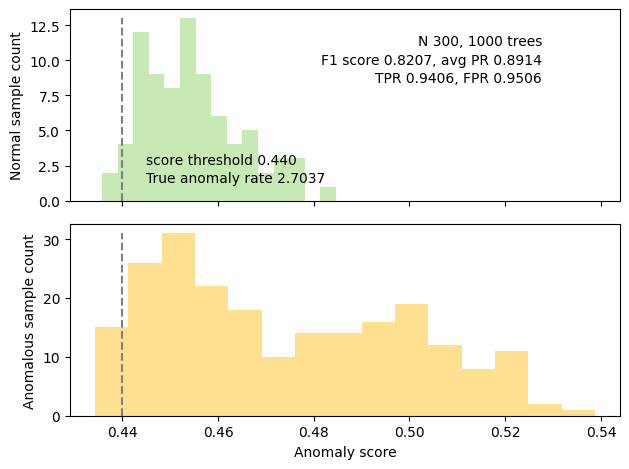

In [123]:
# if __name__ == '__main__': # dask seems to need this
    # launch with "python plot_anomalies.py http.csv attack 20000 256 100 99"
    # or, "python plot_anomalies.py cancer.csv diagnosis all 5 1000 80
    
# for the random survival analysis data, try to use "python plot_anomalies.py survival.csv status(risk score) all 5 1000 80"
# datafile = df_data_set
# targetcol = score
sample_size = 5
n_trees = 1000
desired_TPR = 80
desired_TPR /= 100.0
print("desired_tpr",desired_TPR)
val = 'all'

# df = pd.read_csv(datafile)

if val=='all':
    N = len(telecom_data)
    # print(N)
# else:
#     N = int(sys.argv[3])

df = telecom_data.sample(300)  # grab random subset (too slow otherwise)
# print(df.columns)
X, y = df[['Gender','Age','Married','Number of Dependents','Zip Code','Number of Referrals', 'Tenure in Months']], df['Customer Status']
plot_anomalies(X, y, sample_size=sample_size, n_trees=n_trees, desired_TPR=desired_TPR, bins=15)

In [ ]:
y.unique()


array([1, 3, 2], dtype=int64)